# TP4 - Facial Expression Recognition 

<div>
<b>Student:</b> Jiwon KANG<br>
<b>Date:</b> 18 November, 2024<br>
<b>Description:</b>ROB311 - Facial Expression Recognition<br>
</div>


## Facial Expression Recognition - KNN with FER-2013 dataset

This task is to classify the emotions given a static face image with KNN. The goal for this task is to achieve higher accuracy than the baseline below.

<img src="IMG_5677.JPG" alt="baseline" width="500"/>
<img src="IMG_5676.jpeg" alt="baseline" width="500"/>


As in the task description, we will extract image features to get better results.

### Import libraries

In [30]:
import os
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.utils import shuffle
from skimage.io import imread
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

We will use Local Binary Patterns (LBP) as a feature extraction technology.


In [41]:
def lbp(image, block_size, radius):
    height, width = image.shape
    if height % block_size != 0 or width % block_size != 0:
        raise ValueError("Block size must evenly divide the image dimensions!")

    n_points = 8 * radius
    num_blocks = int(height / block_size)
    lbp_features = []

    for i in range(num_blocks):
        for j in range(num_blocks):
            i_start, j_start = i * block_size, j * block_size
            block = image[i_start:i_start + block_size, j_start:j_start + block_size]
            lbp = local_binary_pattern(block, n_points, radius, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
            lbp_features.extend(hist)

    return np.array(lbp_features)

### Confusion matrix 

In [29]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)

    for i in range(conf_matrix.shape[0]): 
        for j in range(conf_matrix.shape[1]):  
            plt.text(j, i, conf_matrix[i, j],
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

    plt.tight_layout()
    plt.show()

### Prepare the data 

In [46]:
def load_data(base_path, block_size=16, radius=1):
    X = []
    y = []
    class_names = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])  
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):  
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                try:
                    
                    img = imread(file_path, as_gray=True)
                    img_resized = np.resize(img, (48, 48))  
                    
                    features = lbp(img_resized, block_size, radius)
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y), class_names


In [47]:
train_path = "archive/train"
test_path = "archive/test"

X_train, y_train, class_names = load_data(train_path, block_size=16, radius=1)
X_test, y_test, _ = load_data(test_path, block_size=16, radius=1)

print(f"Train data: {X_train.shape}, Test data: {X_test.shape}")

Train data: (28709, 90), Test data: (7178, 90)


In [48]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [49]:
print(f"Class Names: {class_names}")
print(f"Number of Classes in Class Names: {len(class_names)}")

Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of Classes in Class Names: 7


### Train KNN model 

Classification Report (KNN):
              precision    recall  f1-score   support

       angry       0.23      0.36      0.28       958
     disgust       0.27      0.27      0.27       111
        fear       0.27      0.28      0.27      1024
       happy       0.35      0.44      0.39      1774
     neutral       0.28      0.23      0.25      1233
         sad       0.30      0.16      0.21      1247
    surprise       0.44      0.31      0.36       831

    accuracy                           0.30      7178
   macro avg       0.30      0.29      0.29      7178
weighted avg       0.31      0.30      0.30      7178



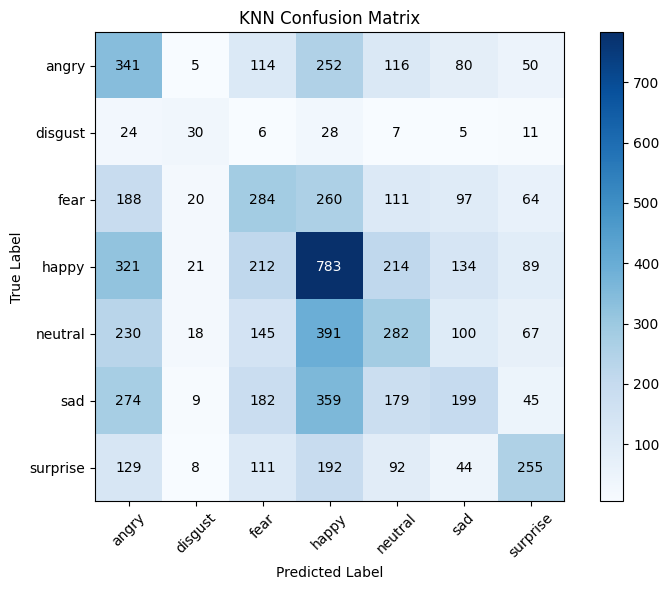

In [50]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred, target_names=class_names))

plot_confusion_matrix(y_test, y_pred, class_names, title="KNN Confusion Matrix")

However, as we can see from the results, the number of data for each emotion is different. 

For example, 'happy' has 1774 data, which is enough to learn, but 'digust' has 111 data, which is not enough for sufficient learning.

So, we can normalize the confusion matrix, then we can check the proportion of each class. 

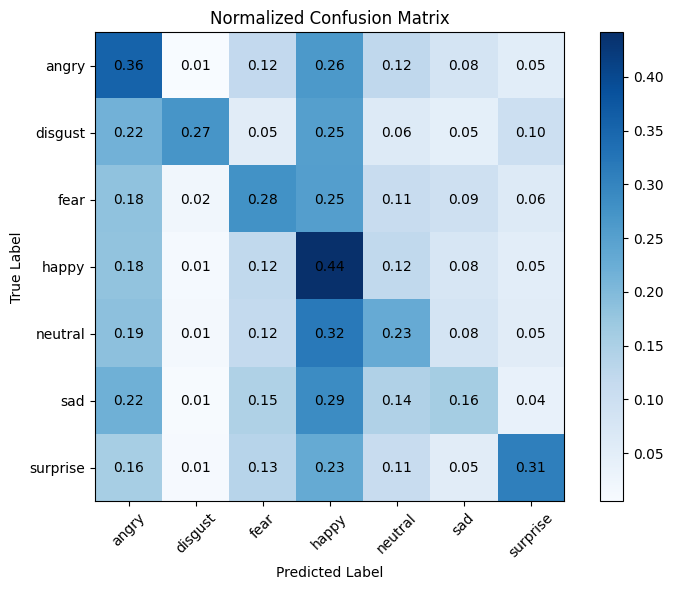

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j, i, f"{conf_matrix_normalized[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if conf_matrix_normalized[i, j] > 0.5 else "black")

plt.tight_layout()
plt.show()


When there is an imbalance in the dataset, the model cannot properly learn the distribution of a small number of classes (minority), which causes overfitting of the majority class and causes the problem of classifying any data into the major class. 

Therefore, I applied the oversampling technique to reduce the imbalance of the dataset.

I used is SMOTE.

### SMOTE

Instead of simply replicating data, SMOTE generates new samples of the minority class.

It generates new data in the linear interval between a specific minority class sample and its knn.
This expands the data distribution of the minority class, thereby mitigating imbalance while preventing overfitting.

As we can observe in the picture, 

<img src="download.png" alt="baseline" width="500"/>

1. Select a random data X from the minority class.

2. Compute the k nearest neighbors around X.

3. Randomly select one of the neighbors, and linearly interpolate between X and the selected neighbor to generate a new sample.

Classification Report (SMOTE + KNN):
              precision    recall  f1-score   support

       angry       0.22      0.40      0.28       958
     disgust       0.07      0.65      0.13       111
        fear       0.27      0.35      0.30      1024
       happy       0.46      0.09      0.15      1774
     neutral       0.29      0.22      0.25      1233
         sad       0.33      0.20      0.25      1247
    surprise       0.40      0.53      0.46       831

    accuracy                           0.27      7178
   macro avg       0.29      0.35      0.26      7178
weighted avg       0.34      0.27      0.26      7178



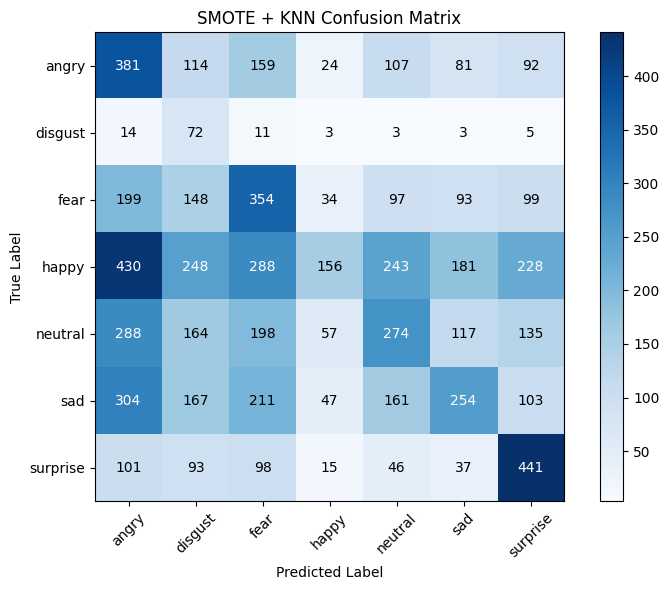

In [52]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = knn_smote.predict(X_test)
print("Classification Report (SMOTE + KNN):")
print(classification_report(y_test, y_pred_smote, target_names=class_names))

plot_confusion_matrix(y_test, y_pred_smote, class_names, title="SMOTE + KNN Confusion Matrix")

The accuracy is lower

## SVM

SVM may be better suited than KNN to handle minority classes and non-linear data.

In [53]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [55]:
train_path = "archive/train"
test_path = "archive/test"

X_train, y_train, class_names = load_data(train_path, block_size=16, radius=1)
X_test, y_test, _ = load_data(test_path, block_size=16, radius=1)

print(f"Train data: {X_train.shape}, Test data: {X_test.shape}")

Train data: (28709, 90), Test data: (7178, 90)


Classification Report (Original Data with SVM):
              precision    recall  f1-score   support

       angry       0.31      0.09      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.33      0.09      0.14      1024
       happy       0.32      0.73      0.45      1774
     neutral       0.32      0.25      0.28      1233
         sad       0.33      0.31      0.32      1247
    surprise       0.49      0.27      0.34       831

    accuracy                           0.33      7178
   macro avg       0.30      0.25      0.24      7178
weighted avg       0.34      0.33      0.29      7178



/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


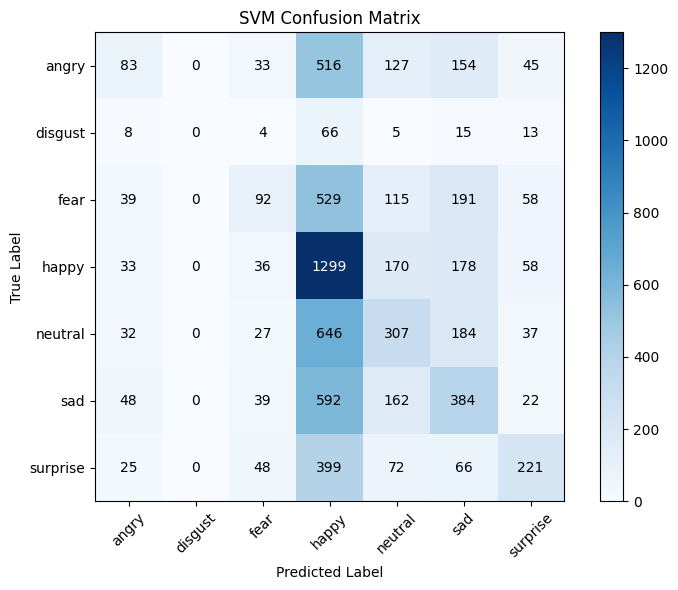

In [56]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) 
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("Classification Report (Original Data with SVM):")
print(classification_report(y_test, y_pred_svm, target_names=class_names))

plot_confusion_matrix(y_test, y_pred_svm, class_names, title="SVM Confusion Matrix")

### CNN

CNN is suitable for processing image data and can learn complex patterns, so it is likely to perform better than KNN.

In [58]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=10, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)


cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(train_generator, epochs=20, validation_data=test_generator)

loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {accuracy * 100:.2f}%")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/20


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.2724 - loss: 1.7771 - val_accuracy: 0.4099 - val_loss: 1.5304
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3912 - loss: 1.5641 - val_accuracy: 0.4519 - val_loss: 1.4258
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4220 - loss: 1.4896 - val_accuracy: 0.4748 - val_loss: 1.3677
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4477 - loss: 1.4285 - val_accuracy: 0.4855 - val_loss: 1.3439
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.4594 - loss: 1.4008 - val_accuracy: 0.4979 - val_loss: 1.3036
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.4653 - loss: 1.3773 - val_accuracy: 0.5060 - val_loss: 1.2783
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4774 - loss: 1.3536 - val_accuracy: 0.5134 - val_loss: 1.2673
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4841 - loss: 1.3390 - val_accurac